<a href="https://colab.research.google.com/github/thiagolermen/ml-course/blob/main/src/3-logistic-regression/PyTorch-logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with PyTorch

We'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: image classification. We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

## Imports

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

## Dataset

In [2]:
dataset = MNIST(root='data/', download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
test_dataset = MNIST(root='data/', train=False)

In [4]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F9EC7908BD0>, 5)

Label: 5


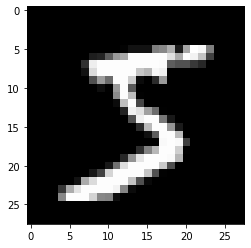

In [5]:
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print(f'Label: {label}')

### Data preprocessing

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [6]:
import torchvision.transforms as transforms

In [7]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [8]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively.

In [9]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


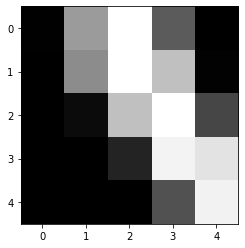

In [10]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

Split the training and cross-validation set

In [12]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
print(f'{len(train_ds)}, {len(val_ds)}')

50000, 10000


Create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [14]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # combine accuracies
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [51]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [52]:
input_size = 28*28
num_classes = 10
model = MnistModel()

In [53]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [54]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0038,  0.0210,  0.0042,  ...,  0.0231, -0.0144, -0.0097],
         [-0.0350,  0.0239, -0.0334,  ..., -0.0035, -0.0045,  0.0123],
         [ 0.0352, -0.0273,  0.0150,  ..., -0.0121,  0.0004, -0.0343],
         ...,
         [ 0.0312, -0.0044,  0.0253,  ..., -0.0303,  0.0011, -0.0313],
         [-0.0356,  0.0051, -0.0238,  ..., -0.0194,  0.0024,  0.0340],
         [-0.0184,  0.0090,  0.0332,  ..., -0.0196, -0.0341, -0.0015]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0222,  0.0321,  0.0141, -0.0217, -0.0197, -0.0148,  0.0270,  0.0133,
          0.0028, -0.0205], requires_grad=True)]

## Train

In [55]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = [] # for recording epoch-wise results

  for epoch in range(epochs):

    # training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

We are now ready to train the model. Let's train for five epochs and look at the results.

In [56]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9816, val_acc: 0.5782
Epoch [1], val_loss: 1.7051, val_acc: 0.7159
Epoch [2], val_loss: 1.4997, val_acc: 0.7593
Epoch [3], val_loss: 1.3451, val_acc: 0.7807
Epoch [4], val_loss: 1.2264, val_acc: 0.7939


In [57]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1333, val_acc: 0.8025
Epoch [1], val_loss: 1.0588, val_acc: 0.8102
Epoch [2], val_loss: 0.9978, val_acc: 0.8168
Epoch [3], val_loss: 0.9472, val_acc: 0.8204
Epoch [4], val_loss: 0.9044, val_acc: 0.8242


In [58]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8679, val_acc: 0.8276
Epoch [1], val_loss: 0.8362, val_acc: 0.8309
Epoch [2], val_loss: 0.8085, val_acc: 0.8335
Epoch [3], val_loss: 0.7841, val_acc: 0.8359
Epoch [4], val_loss: 0.7623, val_acc: 0.8383


In [59]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7429, val_acc: 0.8403
Epoch [1], val_loss: 0.7253, val_acc: 0.8428
Epoch [2], val_loss: 0.7094, val_acc: 0.8438
Epoch [3], val_loss: 0.6948, val_acc: 0.8449
Epoch [4], val_loss: 0.6815, val_acc: 0.8469


## Test

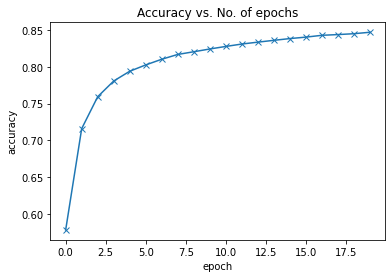

In [61]:
history = history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [62]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


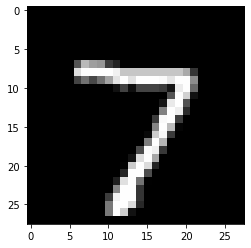

In [64]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [65]:
def predict_image(img, model):
    xb = img.unsqueeze(0) # adds another dimension to see it as a batch
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


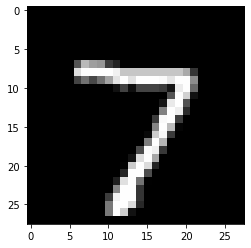

In [66]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


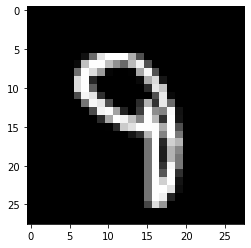

In [68]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Saving the model

In [69]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [70]:
model2 = MnistModel()

In [71]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-3.4328e-02,  2.4648e-02,  1.1744e-02,  ...,  3.4217e-03,
                        3.4903e-02, -3.3165e-02],
                      [-1.2658e-02,  1.4311e-02,  3.2881e-02,  ..., -1.6050e-03,
                       -2.6487e-02,  3.6208e-03],
                      [ 2.1052e-02, -1.8887e-02, -1.9129e-02,  ..., -1.3491e-02,
                        2.4621e-02,  1.3303e-02],
                      ...,
                      [-2.6563e-02,  2.1846e-02, -3.2031e-02,  ...,  3.1074e-02,
                        1.3954e-03, -2.2105e-02],
                      [ 1.2937e-02, -7.6674e-03, -3.6380e-05,  ...,  8.0587e-03,
                       -3.4392e-02, -1.4400e-02],
                      [ 3.4463e-02, -3.5340e-02, -1.7450e-02,  ...,  9.3909e-03,
                       -4.5793e-04,  2.5421e-02]])),
             ('linear.bias',
              tensor([ 0.0264,  0.0249,  0.0283,  0.0045, -0.0087,  0.0217, -0.0208,  0.0301,
                      -0.0174,

In [72]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))

<All keys matched successfully>

In [73]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0038,  0.0210,  0.0042,  ...,  0.0231, -0.0144, -0.0097],
                      [-0.0350,  0.0239, -0.0334,  ..., -0.0035, -0.0045,  0.0123],
                      [ 0.0352, -0.0273,  0.0150,  ..., -0.0121,  0.0004, -0.0343],
                      ...,
                      [ 0.0312, -0.0044,  0.0253,  ..., -0.0303,  0.0011, -0.0313],
                      [-0.0356,  0.0051, -0.0238,  ..., -0.0194,  0.0024,  0.0340],
                      [-0.0184,  0.0090,  0.0332,  ..., -0.0196, -0.0341, -0.0015]])),
             ('linear.bias',
              tensor([-0.0262,  0.1252, -0.0056, -0.0447,  0.0114,  0.0268,  0.0103,  0.0516,
                      -0.0797, -0.0342]))])

In [74]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.860644519329071, 'val_loss': 0.642776608467102}